In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import keras

from datasets import example_datasets, to_numpy
from models import mixture_poissons,location_specific_linear, CustomPenalizedMixtureDecisionModel, get_mixture
from metrics import mixture_poi_loss, get_bpr_loss_func, mix_bpr, get_penalized_bpr_loss_func_mix, cross_ratio_decision, get_perturbed_bpr_func
from experiments import training_loop, training_loop_score_function_trick, score_function_trick, overall_gradient_calculation
from plotting_funcs import plot_losses, plot_frontier, sample_and_plot

import scipy

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

import matplotlib.pyplot as plt
import resource
import datetime
import time

2024-05-21 07:57:03.908483: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-21 07:57:03.955228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 07:57:03.955252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 07:57:03.956386: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 07:57:03.963918: I tensorflow/core/platform/cpu_feature_guar

In [2]:
num_locations_S=4
# model these 4 locations with mixture of 4 components
num_components_C=num_locations_S
scale = 1
means = [5.0, 15.0, 25.0, 35.0]

# simulate data for each location
data_distributions = [scipy.stats.norm(loc=mean, scale=scale) for mean in means]

num_examples_T = 1000
y_TS = np.array([dist.rvs(num_examples_T) for dist in data_distributions]).T

# x doesn't matter because we aren't actually learning
num_features_F = 20
x_TF = np.random.randn(num_examples_T, num_features_F)


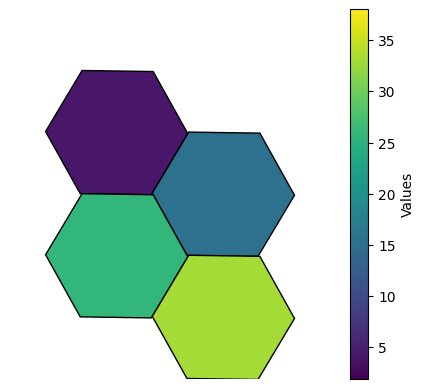

In [3]:
sample_and_plot(data_distributions)

2024-05-21 08:05:01.671309: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-21 08:05:01.671341: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: s1cmp008.pax.tufts.edu
2024-05-21 08:05:01.671347: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: s1cmp008.pax.tufts.edu
2024-05-21 08:05:01.671420: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.129.3
2024-05-21 08:05:01.671444: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.129.3
2024-05-21 08:05:01.671449: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.129.3


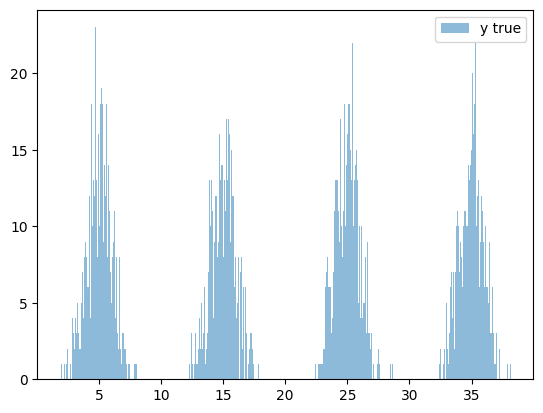

In [4]:
plt.hist(tf.reshape(y_TS, [-1]).numpy(),alpha=0.5, bins=1000, label='y true')
plt.legend()

In [14]:
class MixtureWeightLayer(keras.layers.Layer):
    """Dumb layer that just returns mixture weights
    Constrained to unit norm
    """
    def __init__(self, num_components, **kwargs):
        super().__init__(**kwargs)
        self.w = self.add_weight(shape=( 1,num_components, ),
            initializer="uniform",
            trainable=True,
        )
        
        self.softmax = keras.layers.Softmax(axis=1)

    def call(self, inputs):
        return tf.squeeze(self.softmax(self.w))

In [15]:
# build layers
inputs = keras.Input(shape=num_features_F)
component_layers = [keras.layers.Dense(1, activation='softplus') for _ in range(num_components_C)]
mixture_weight_layers = [MixtureWeightLayer(num_components_C) for _ in range(num_locations_S)]

# Add a component dimension to outputs of each component model
reshape_layer = keras.layers.Reshape(name='mix_reshape', target_shape=(-1,1))
# Concatenate components along new dimension
concat_layer = keras.layers.Concatenate(name='mix_concat',axis=-1)

# get tfp mixture model
mixture_distribution_layer = tfp.layers.DistributionLambda(lambda params: 
        tfp.distributions.MixtureSameFamily(mixture_distribution=
                                                tfp.distributions.Categorical(probs=params[0]),
                                            components_distribution=
                                                tfp.distributions.Normal(loc=params[1],
                                                                        scale=scale,
                                                                        validate_args=True)))


In [17]:
# build model
component_predictions = [component(inputs) for component in component_layers]
combined_components = concat_layer([reshape_layer(member) for member in component_predictions])
mixture_weights = [mixture_weight_layer(inputs) for mixture_weight_layer in mixture_weight_layers]
mixture_distributions = [mixture_distribution_layer([mixture_weight, combined_components]) for mixture_weight in mixture_weights]

combined_outputs = concat_layer([mixture_distribution for mixture_distribution in mixture_distributions])
model = keras.Model(inputs=inputs,outputs=[combined_outputs, mixture_distributions])

In [18]:
output = model(x_TF)

In [55]:
output

[<tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
 array([[ 0.523197  ,  0.23844159,  0.46573147,  0.9631216 ],
        [ 0.95033926, -3.0627115 , -0.06079197,  4.3162107 ],
        [ 0.50016767,  0.29394156,  0.09388715,  2.3104806 ],
        ...,
        [ 0.9542312 ,  1.2280988 ,  0.7528852 ,  0.8011756 ],
        [ 2.8940125 , -0.45148706, -1.00174   ,  0.5286344 ],
        [ 0.16556817,  0.4705637 ,  0.62261844,  0.62448776]],
       dtype=float32)>,
 [<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000, 1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000, 1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000, 1] event_shape=[] dtype=float32>,
  <tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1000, 1] event_shape=[] dtype=float32>]]

In [10]:
model.trainable_variables

[<tf.Variable 'dense/kernel:0' shape=(20, 1) dtype=float32, numpy=
 array([[-0.44139463],
        [ 0.1734016 ],
        [ 0.18818277],
        [ 0.2672698 ],
        [-0.28165013],
        [ 0.04364759],
        [ 0.31165332],
        [-0.45609826],
        [-0.2808326 ],
        [ 0.08909208],
        [-0.04632321],
        [-0.50702524],
        [ 0.44396454],
        [-0.06608495],
        [-0.40317637],
        [-0.37128448],
        [ 0.37763506],
        [ 0.2671678 ],
        [ 0.27852488],
        [-0.2938608 ]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'dense_1/kernel:0' shape=(20, 1) dtype=float32, numpy=
 array([[-0.19296914],
        [ 0.08928233],
        [-0.37048566],
        [ 0.50307935],
        [ 0.11831331],
        [-0.08207753],
        [-0.13279206],
        [ 0.31842232],
        [-0.12008768],
        [-0.488354  ],
        [-0.13230091],
        [ 0.24345583],
        [-0.18222862

In [23]:
 # Set linear weights to 0
for index in [0, 2, 4, 6]:
    variable = model.trainable_variables[index]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    variable.assign(tf.zeros(variable.shape))

# set biases to true value
for index, bias in zip([1, 3, 5, 7], [5.0, 15.0, 25.0, 35.0]):
    variable = model.trainable_variables[index]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    variable.assign(tfp.math.softplus_inverse([bias]))

for i, index in enumerate([-4, -3, -2, -1]):
    variable = model.trainable_variables[index]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')

    weights = np.array([[0,0,0,0]], dtype=np.float32)
    weights[0,i] = 1
    variable.assign(tf.math.log(weights+1e-13))

Name: dense_8/kernel:0
Shape: (20, 1)
Name: dense_9/kernel:0
Shape: (20, 1)
Name: dense_10/kernel:0
Shape: (20, 1)
Name: dense_11/kernel:0
Shape: (20, 1)
Name: dense_8/bias:0
Shape: (1,)
Name: dense_9/bias:0
Shape: (1,)
Name: dense_10/bias:0
Shape: (1,)
Name: dense_11/bias:0
Shape: (1,)
Name: Variable:0
Shape: (1, 4)
Name: Variable:0
Shape: (1, 4)
Name: Variable:0
Shape: (1, 4)
Name: Variable:0
Shape: (1, 4)


In [24]:
outputs, mixture_models = model(x_TF)

In [42]:
num_score_func_samples=2

In [40]:
sample_ys_MBS = [mixture_model.sample(num_score_func_samples) for mixture_model in mixture_models]
stopped_samples = tf.stop_gradient(sample_ys_MBS)
sample_y_MBS = concat_layer(sample_ys_MBS)
print(f'Sample y shape {sample_y_MBS.shape}')


sample_log_probs_MBS = concat_layer([mixture_model.log_prob(y_sample_MBS) for mixture_model, y_sample_MBS in zip(mixture_models, stopped_samples)])

# no cross-ratio decision here
sample_decisions_MBS = tf.identity(sample_y_MBS)
expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)
print(f'Expected decisions shape {expected_decisions_BS.shape}')
loss_B = keras.losses.mean_squared_error(y_TS, expected_decisions_BS)
loss = tf.reduce_mean(loss_B)

Sample y shape (50, 1000, 4)
Expected decisions shape (1000, 4)


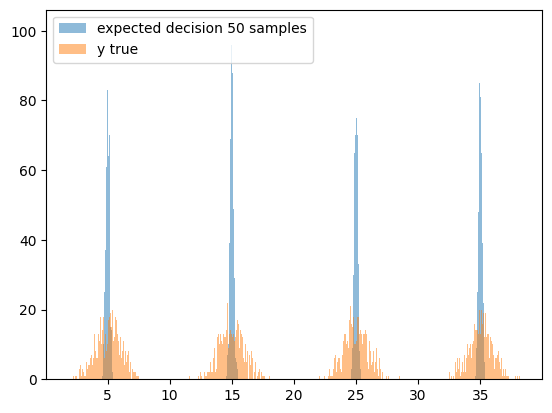

In [41]:
plt.hist(tf.reshape(expected_decisions_BS, [-1]).numpy(),alpha=0.5, bins=1000, label=f'expected decision {num_score_func_samples} samples')
plt.hist(tf.reshape(y_TS, [-1]).numpy(),alpha=0.5, bins=1000, label='y true')
plt.legend()

In [52]:
gradient_magnitudes = []
master_magnitudes = []
param_vals = []
losses = []
mean_log_probs = []
for param_value in np.linspace(20, 30, 50, dtype=np.float32):
    print(param_value)
    variable = model.trainable_variables[5]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')
    variable.assign(tfp.math.softplus_inverse([param_value]))
    
    start = time.time()

    for sample in range(1):
        with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape, tf.GradientTape() as master_tape:
            outputs, mixture_models = model(x_TF)

            sample_ys_MBS = [mixture_model.sample(num_score_func_samples) for mixture_model in mixture_models]
            stopped_samples = tf.stop_gradient(sample_ys_MBS)
            sample_y_MBS = concat_layer(sample_ys_MBS)

            sample_log_probs_MBS = concat_layer([mixture_model.log_prob(y_sample_MBS) for mixture_model, y_sample_MBS in zip(mixture_models, stopped_samples)])

            # no cross-ratio decision here
            sample_decisions_MBS = tf.identity(sample_y_MBS)
            expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)
            loss_B = keras.losses.mean_squared_error(y_TS, expected_decisions_BS)
            loss = tf.reduce_mean(loss_B)

        jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
        param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]
        
        loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
        overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

        master_gradient = master_tape.gradient(loss_B, model.trainable_weights)

        param_vals.append(param_value)
        gradient_magnitudes.append(overall_gradient[5])
        master_magnitudes.append(master_gradient[5])
        losses.append(loss)
        mean_log_probs.append(tf.reduce_mean(sample_log_probs_MBS[:,:,2]))
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

20.0
Name: dense_10/bias:0
Shape: (1,)
Elapsed time 3.6995511054992676
20.204082
Name: dense_10/bias:0
Shape: (1,)
Elapsed time 5.04484224319458
20.408163
Name: dense_10/bias:0
Shape: (1,)
Elapsed time 3.3252780437469482
20.612246
Name: dense_10/bias:0
Shape: (1,)
Elapsed time 3.289973497390747
20.816326
Name: dense_10/bias:0
Shape: (1,)
Elapsed time 3.296761989593506
21.020409
Name: dense_10/bias:0
Shape: (1,)
Elapsed time 3.2872703075408936
21.22449
Name: dense_10/bias:0
Shape: (1,)
Elapsed time 3.2797796726226807
21.428572
Name: dense_10/bias:0
Shape: (1,)
Elapsed time 3.302361011505127
21.632652
Name: dense_10/bias:0
Shape: (1,)
Elapsed time 3.295227289199829
21.836735
Name: dense_10/bias:0
Shape: (1,)
Elapsed time 3.25032114982605
22.040817
Name: dense_10/bias:0
Shape: (1,)
Elapsed time 3.2874300479888916
22.244898
Name: dense_10/bias:0
Shape: (1,)
Elapsed time 3.22925066947937
22.44898
Name: dense_10/bias:0
Shape: (1,)
Elapsed time 3.257108688354492
22.65306
Name: dense_10/bias:0

In [54]:
gradient_magnitudes

[<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.18442559], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.57700425], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.663656], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9790185], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9574877], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.76364005], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8940284], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.8394653], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.89529455], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.4174416], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.3655683], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.3430283], dtype=float32)>,
 <tf.Tensor: 

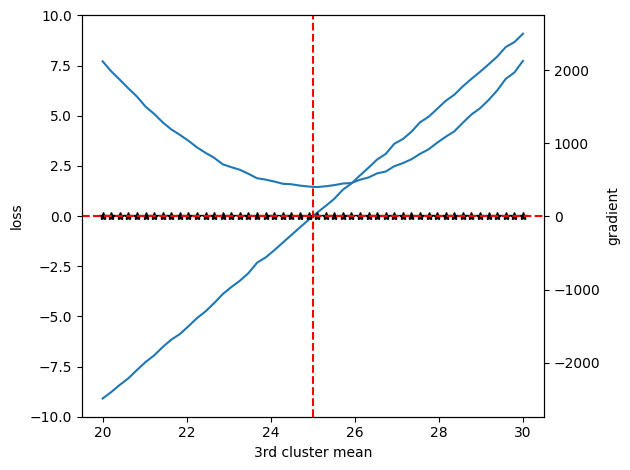

In [53]:
# plot with 2 different scales, 1 y axis for each graph:
fig, ax1 = plt.subplots()

# Plot the first line on ax1
ax1.set_xlabel('3rd cluster mean')
ax1.set_ylabel('loss')
ax1.plot(param_vals, losses)
ax1.tick_params(axis='y')
ax1.set_ylim([-10, 10])

# Create ax2, which shares the same x-axis as ax1
ax2 = ax1.twinx()
ax2.set_ylabel('gradient')
ax2.plot(param_vals, master_magnitudes)
ax2.plot(param_vals, gradient_magnitudes, 'k*')
ax2.tick_params(axis='y')

#ax2.set_ylim([-1000, 1000])
#plot vertical line at x=25
plt.axvline(x=25, color='r', linestyle='--')
plt.axhline(y=0, color='r', linestyle='--')
fig.tight_layout()
plt.show()


Our objective is to minimize the loss incurred by action $\theta$ under outcome $y_t$, where $\theta$ is a function of a model with parameters $\phi$, $\theta(\phi) = f(\hat{y}), \hat{y}\sim p_\phi$.
$$\min_\phi \sum^T \mathcal{L}(\theta(\phi), y_t)$$

We can use stochastic gradient descent to solve this optimization problem
$$\nabla_\phi \mathcal{L}(\theta(\phi), y_t) = \nabla_\phi \theta \nabla_\theta \mathcal{L} $$

Calculating $\nabla_\phi \theta$ requires use of the score function (or REINFORCE) estimator:
$$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M (\nabla_\phi \log p_\phi(y^m) )f(y^m)$$

This makes our overall gradient calculation:
$$\nabla_\phi \mathcal{L}(\theta(\phi), y_t) =  \nabla_\theta \mathcal{L}\frac{1}{M} \sum_{m=1}^M (\nabla_\phi \log p_\phi(y^m) )f(y^m) $$

We can visualize all the quantities below

In [20]:
num_score_func_samples=2

In [51]:
def overall_gradient_calculation(gradient_BSp, decision_gradient_BS):
    num_param_dims = tf.rank(gradient_BSp)-2
    num_param_dims_tf = tf.cast(num_param_dims, tf.int32)
    new_shape = tf.concat([tf.shape(decision_gradient_BS), tf.ones([num_param_dims_tf], tf.int32)], axis=0)
    decision_gradient_BSp=tf.reshape(decision_gradient_BS, new_shape)
    #decision_gradient_BSp = tf.reshape(decision_gradient_BS, decision_gradient_BS.shape + [1]*num_param_dims.numpy())

    overall_gradient_BSp = gradient_BSp*decision_gradient_BSp

    # sum over batch and location
    overall_gradient_Bp = tf.reduce_mean(overall_gradient_BSp, axis=1)
    overall_gradient = tf.reduce_mean(overall_gradient_Bp, axis=0)
    return overall_gradient

In [67]:
my_gradient_calc = []
true_gradient_calc = []
param_vals = []
losses = []
log_prob_samples = []
jacobian_vals = []
mean_decisions = []
mean_param_grad = []
mean_loss_grad = []
for param_value in np.linspace(20, 30, 10, dtype=np.float32):
    print(param_value)
    variable = model.trainable_variables[5]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')
    variable.assign(tfp.math.softplus_inverse([param_value]))
    
    start = time.time()

    for sample in range(5):
        with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape, tf.GradientTape() as master_tape:
            mixture_model = model(x_TF)

            sample_y_MBS = mixture_model.sample(num_score_func_samples)
            stopped_samples_MBS = tf.stop_gradient(sample_y_MBS)
            sample_log_probs_MBS = mixture_model.log_prob(stopped_samples_MBS)

            # no cross-ratio decision here. Do want gradients in these tensors
            sample_decisions_MBS = tf.identity(sample_y_MBS)
            expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)

            loss_B = keras.losses.mean_squared_error(y_TS, expected_decisions_BS)
            loss = tf.reduce_mean(loss_B)

        jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
        param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]
        
        loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
        overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

        master_gradient = master_tape.gradient(loss_B, model.trainable_weights)

        param_vals.append(param_value)
        my_gradient_calc.append(overall_gradient[5])
        true_gradient_calc.append(master_gradient[5])
        losses.append(loss)
        log_prob_samples.append(tf.reduce_mean(sample_log_probs_MBS[:,:,2]))
        jacobian_vals.append(tf.reduce_mean(jacobian_pMBS[5][:,:,2]))
        mean_param_grad.append(tf.reduce_mean(param_gradient_pBS[5][:,2]))
        mean_decisions.append(tf.reduce_mean(sample_decisions_MBS[:,:,2]))
        mean_loss_grad.append(tf.reduce_mean(loss_gradients_BS[:,2]))
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

20.0
Name: dense_2/bias:0
Shape: (1,)
Elapsed time 16.2295663356781
21.11111
Name: dense_2/bias:0
Shape: (1,)
Elapsed time 16.21221160888672
22.222221
Name: dense_2/bias:0
Shape: (1,)
Elapsed time 16.015602111816406
23.333334
Name: dense_2/bias:0
Shape: (1,)
Elapsed time 17.679743766784668
24.444445
Name: dense_2/bias:0
Shape: (1,)
Elapsed time 16.087511777877808
25.555555
Name: dense_2/bias:0
Shape: (1,)
Elapsed time 16.076491594314575
26.666666
Name: dense_2/bias:0
Shape: (1,)
Elapsed time 16.245964765548706
27.777779
Name: dense_2/bias:0
Shape: (1,)
Elapsed time 16.231163501739502
28.88889
Name: dense_2/bias:0
Shape: (1,)
Elapsed time 16.129249095916748
30.0
Name: dense_2/bias:0
Shape: (1,)
Elapsed time 16.116664171218872


Text(0.5, 1.0, '$\\log p(y^m)$ Average log prob of score function samples')

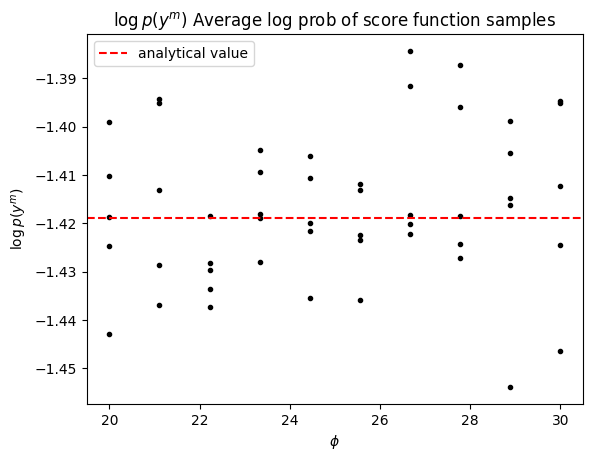

In [68]:
plt.plot(param_vals, log_prob_samples, 'k.')
# plot horizontal line at -1.41894
plt.axhline(y=-1.41894, color='r', linestyle='--', label='analytical value')
plt.ylabel('$\log p(y^m)$')
plt.xlabel('$\phi$')
plt.legend()
plt.title("$\log p(y^m)$ Average log prob of score function samples")

$$\mathbb{E} [\log p(y^m)] =\mathbb{E} [\log \mathcal{N}(y^M|\mu, \sigma^2)]$$
substitute pdf
$$\mathbb{E} [\log \mathcal{N}(y^M|\mu, \sigma^2)] = \mathbb{E} [\log \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(y^m - \mu)^2}{2\sigma^2} \right)]$$
linearity of expectation
$$ = -\frac{1}{2} \log(2\pi\sigma^2) - \frac{1}{2\sigma^2}\mathbb{E} [(y^m-\mu)^2 ]$$
the expectation is the definition of variance
$$ = -\frac{1}{2} \log(2\pi\sigma^2) - \frac{1}{2\sigma^2} \sigma^2$$ 
plug in $\sigma=1$
$$ = -\frac{1}{2} \log(2\pi 1^2)- \frac{1}{2}$$
$$ = -1.41894...$$

Text(0.5, 1.0, '$\\nabla_\\phi \\log p(y^m)$ gradient of  log prob of score function samples')

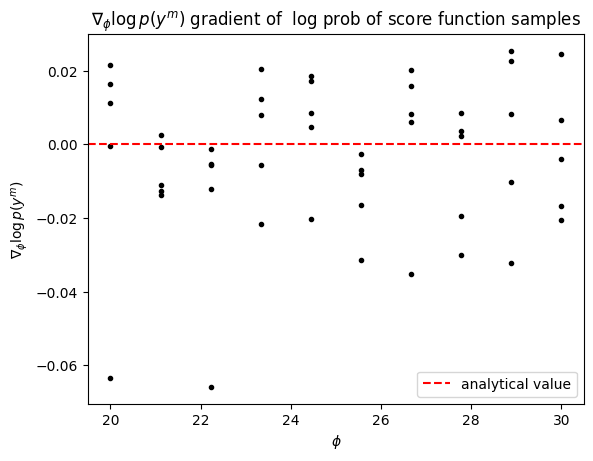

In [69]:
plt.plot(param_vals, jacobian_vals,'k.')
plt.ylabel(r'$\nabla_\phi \log p(y^m)$')
plt.axhline(y=0, color='r', linestyle='--', label='analytical value')
plt.xlabel('$\phi$')
plt.legend()
plt.title(r"$\nabla_\phi \log p(y^m)$ gradient of  log prob of score function samples")

substitute pdf
$$\mathbb{E} [\nabla_\mu \log \mathcal{N}(y^M|\mu, \sigma^2)] = \mathbb{E} [\nabla_\mu \log \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left( -\frac{(y^m - \mu)^2}{2\sigma^2} \right)]$$
linearity of expectation/ discarding 0 gradients
$$=-\mathbb{E}[ \nabla_\mu (y^m-\mu)^2]$$
differentiating
$$=-\mathbb{E}[ -2(y^m-\mu)] =  -\mathbb{E}[ -2(y^m)] -2\mu $$
expectation of $y^m$ is $\mu$
$$= 2\mu-2\mu = 0$$



Text(0.5, 1.0, "$f(y^m)$ Average 'decision' ")

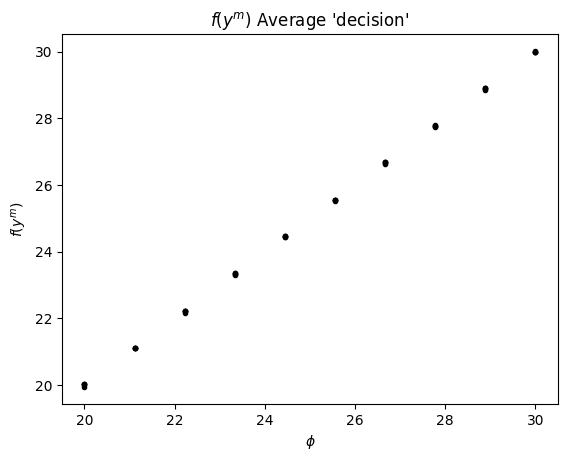

In [70]:
plt.plot(param_vals, mean_decisions ,'k.')
plt.ylabel('$f(y^m)$')
plt.xlabel('$\phi$')
plt.title("$f(y^m)$ Average 'decision' ")


Text(0.5, 1.0, '$\\nabla_\\phi \\theta = \\frac{1}{M} \\sum_{m=1}^M (\\nabla_\\phi \\log p_\\phi(y^m) )f(y^m)$ Score function estimator of gradient of decision ')

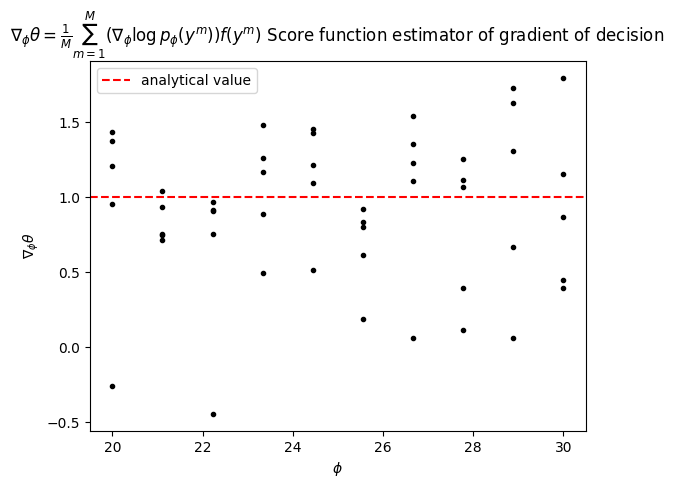

In [71]:
plt.plot(param_vals, mean_param_grad, 'k.')
plt.ylabel(r'$\nabla_\phi \theta$')
plt.axhline(y=1, color='r', linestyle='--', label='analytical value')
plt.legend()
plt.xlabel('$\phi$')
plt.title(r"$\nabla_\phi \theta = \frac{1}{M} \sum_{m=1}^M (\nabla_\phi \log p_\phi(y^m) )f(y^m)$ Score function estimator of gradient of decision ")

$$\nabla_\phi \theta = \nabla_\phi f(y)$$
In this simple example, $f(y)=y$ 
$$\nabla_\phi \mathbb{E} [f(y)] = \nabla_\phi \mathbb{E} [y] $$
Here we visualize the bias parameter $\phi$ that controls the mean of $y$, so we can say $\mathbb{E}[y]=\phi$

$$ = \nabla_\phi \phi = 1 $$

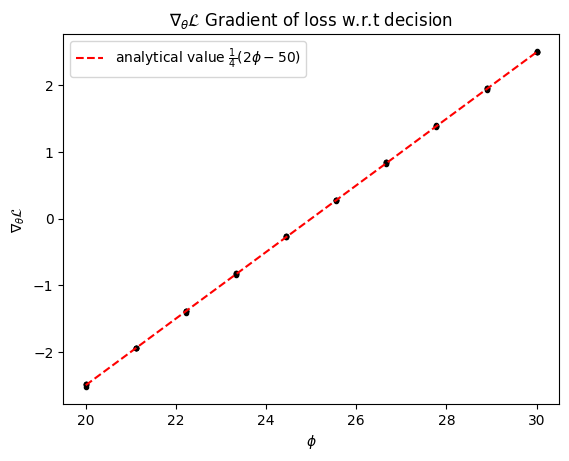

In [72]:
plt.plot(param_vals, mean_loss_grad, 'k.')
plt.ylabel(r'$\nabla_\theta \mathcal{L} $')
plt.xlabel('$\phi$')
plt.title(r"$\nabla_\theta \mathcal{L} $ Gradient of loss w.r.t decision")
# plot 2x-50
plt.plot(param_vals, 1/2*np.array(param_vals)-50/4, 'r--', label=r'analytical value $\frac{1}{4}(2\phi-50)$')
plt.legend()

$$\nabla_\theta \mathcal{L} = \frac{1}{N} \sum_{n=1}^N \nabla_\theta \frac{1}{K}\sum_{k=1}^{K} (y_{n,k} -\theta_k)^2 $$
expanding
$$= \frac{1}{N} \sum_{n=1}^N \nabla_\theta \frac{1}{K}\sum_{k=1}^{K} \theta_k^2 -2\theta_k y_{n,k} + y_{n,k}^2 $$
differentiating
$$= \frac{1}{N} \sum_{n=1}^N \frac{1}{K}\sum_{k=1}^{K} 2\theta_k -2y_n$$
In this case, $K=4$ and $\theta_k =y_{n,k}$ for $k \in 0,1,3$. We also know that all $y_{n,2}=25$
$$= \frac{1}{N} \sum_{n=1}^N \frac{1}{4} (2\theta_2 -50)$$

Text(0.5, 1.0, '$\\nabla_\\phi \\mathcal{L} $ Overall gradient w.r.t model parameters')

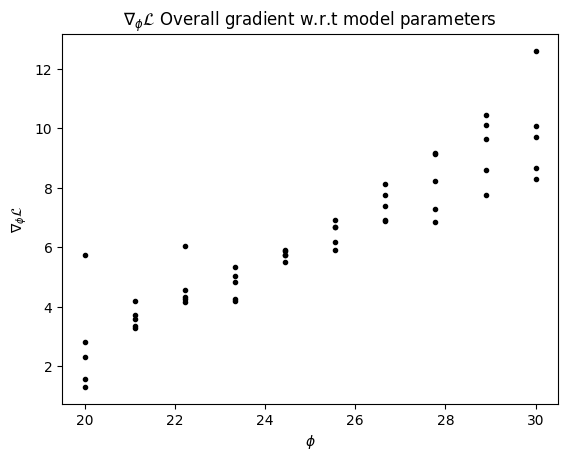

In [73]:
plt.plot(param_vals, my_gradient_calc, 'k.')
plt.ylabel(r'$\nabla_\phi \mathcal{L} $')
plt.xlabel('$\phi$')
plt.title(r"$\nabla_\phi \mathcal{L} $ Overall gradient w.r.t model parameters")

In [89]:
def get_analytical_jacobian(sample_y_MBS):
    jacobian_BS =  tf.reduce_mean(-2.0*(sample_y_MBS-25.0), axis=0)
    return jacobian_BS

In [91]:
tf.reduce_mean(-2.0*(sample_y_MBS-25.0), axis=0)

<tf.Tensor: shape=(2, 1000, 4), dtype=float32, numpy=
array([[[ 4.2313733, 15.095558 , 28.73414  , 34.71288  ],
        [ 4.9758925, 14.634388 , 31.045362 , 35.422607 ],
        [ 4.9610624, 15.138769 , 28.446331 , 35.936195 ],
        ...,
        [ 6.022003 , 15.849764 , 31.27881  , 32.911274 ],
        [ 4.3618393, 12.991319 , 30.320396 , 34.240696 ],
        [ 5.274235 , 15.174047 , 30.928188 , 35.421955 ]],

       [[ 3.6622124, 13.792489 , 28.412468 , 35.084885 ],
        [ 6.4077287, 12.796327 , 30.412313 , 36.457924 ],
        [ 5.591016 , 13.622164 , 31.311525 , 33.953724 ],
        ...,
        [ 5.1328797, 13.134433 , 30.134033 , 34.58638  ],
        [ 5.112401 , 14.927838 , 29.320972 , 34.560654 ],
        [ 6.597426 , 16.109465 , 30.671282 , 35.056015 ]]], dtype=float32)>

In [40]:
my_gradient_calc = []
true_gradient_calc = []
param_vals = []
losses = []
log_prob_samples = []
jacobian_vals = []
mean_decisions = []
mean_param_grad = []
mean_loss_grad = []
for param_value in np.linspace(20, 30, 10, dtype=np.float32):
    print(param_value)
    variable = model.trainable_variables[5]
    print(f'Name: {variable.name}')
    print(f'Shape: {variable.shape}')
    variable.assign(tfp.math.softplus_inverse([param_value]))
    
    start = time.time()

    for sample in range(5):

        mixture_model = model(x_TF)

        sample_y_MBS = mixture_model.sample(num_score_func_samples)
        stopped_samples_MBS = tf.stop_gradient(sample_y_MBS)
        sample_log_probs_MBS = mixture_model.log_prob(stopped_samples_MBS)

        # no cross-ratio decision here. Do want gradients in these tensors
        sample_decisions_MBS = tf.identity(sample_y_MBS)
        expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)

        loss_B = keras.losses.mean_squared_error(y_TS, expected_decisions_BS)
        loss = tf.reduce_mean(loss_B)

        jacobian_MBS = get_analytical_jacobian(sample_y_MBS)
        param_gradient_BS = score_function_trick(jacobian_MBS, sample_decisions_MBS)
        
        loss_gradients_BS = get_analytical_loss_gradient(loss_B, expected_decisions_BS)
        overall_gradient = overall_gradient_calculation(param_gradient_BS, loss_gradients_BS)

        master_gradient = master_tape.gradient(loss_B, model.trainable_weights)

        param_vals.append(param_value)
        my_gradient_calc.append(overall_gradient[5])
        true_gradient_calc.append(master_gradient[5])
        losses.append(loss)
        log_prob_samples.append(tf.reduce_mean(sample_log_probs_MBS[:,:,2]))
        jacobian_vals.append(tf.reduce_mean(jacobian_MBS[:,:,2]))
        mean_param_grad.append(tf.reduce_mean(param_gradient_BS[:,2]))
        mean_decisions.append(tf.reduce_mean(sample_decisions_MBS[:,:,2]))
        mean_loss_grad.append(tf.reduce_mean(loss_gradients_BS[:,2]))
    end = time.time()
    elapsed = end - start
    print(f'Elapsed time {elapsed}')

sample 31.879940032958984
log prob: -2.686025619506836
second opinion log prob -2.6860257969655863


In [36]:
stopped_samples_MBS = stopped_samples

In [34]:
sample_log_probs_MBS

<tf.Tensor: shape=(2, 1000, 4), dtype=float32, numpy=
array([[[-0.9444168 , -1.9898924 , -2.6860256 , -1.1226045 ],
        [-1.1677203 , -0.9214914 , -0.92969114, -1.1109558 ],
        [-0.9418809 , -1.334719  , -1.1742158 , -2.2141728 ],
        ...,
        [-0.92353594, -1.0206163 , -1.2886226 , -1.0237054 ],
        [-1.1636474 , -1.7827543 , -1.2032783 , -0.9251431 ],
        [-2.669829  , -1.2012675 , -1.2906542 , -1.0154294 ]],

       [[-1.724657  , -1.1134567 , -1.4968708 , -1.9819375 ],
        [-1.9832597 , -1.3351443 , -1.379701  , -0.92093456],
        [-1.3076969 , -2.8056345 , -0.9196152 , -1.3728714 ],
        ...,
        [-1.5824087 , -1.1941955 , -0.95632726, -1.035464  ],
        [-4.6314077 , -1.0806998 , -1.0705513 , -2.4472992 ],
        [-2.3839188 , -1.0339077 , -1.9804697 , -1.0793141 ]]],
      dtype=float32)>

In [24]:
mixture_model.components_distribution.mean()

<tf.Tensor: shape=(1000, 1, 4), dtype=float32, numpy=
array([[[ 5., 15., 30., 35.]],

       [[ 5., 15., 30., 35.]],

       [[ 5., 15., 30., 35.]],

       ...,

       [[ 5., 15., 30., 35.]],

       [[ 5., 15., 30., 35.]],

       [[ 5., 15., 30., 35.]]], dtype=float32)>

In [49]:
loss_gradients_BS[:,2]

<tf.Tensor: shape=(1000, 4), dtype=float32, numpy=
array([[-1.2896037 ,  0.13126135,  3.5959883 ,  0.33093452],
       [-0.01830268, -0.11020899,  3.110385  , -0.7450657 ],
       [-0.695359  , -1.295979  ,  1.9381361 , -1.0917511 ],
       ...,
       [-0.6094749 , -0.14813185,  2.627864  ,  0.4541607 ],
       [ 1.0121706 , -0.5669589 ,  2.812273  ,  0.0872612 ],
       [-0.0057683 , -0.39992476,  3.0160418 , -0.15619469]],
      dtype=float32)>

In [50]:
loss_gradients_BS[:,2]

<tf.Tensor: shape=(1000,), dtype=float32, numpy=
array([3.5959883 , 3.110385  , 1.9381361 , 4.1410084 , 2.3602657 ,
       3.3007822 , 2.2457151 , 1.7468281 , 1.2712002 , 2.7286873 ,
       1.8176775 , 1.4583254 , 1.9649811 , 1.9927683 , 2.332326  ,
       2.012639  , 1.965949  , 1.4013081 , 3.1415138 , 2.8578234 ,
       2.4453745 , 2.9092817 , 1.7728243 , 2.2941961 , 3.8243923 ,
       2.6538553 , 1.6582279 , 2.8043604 , 2.2156487 , 2.212453  ,
       3.5257597 , 1.6325817 , 2.593629  , 3.4027138 , 3.2958717 ,
       2.0264158 , 2.736683  , 2.3905525 , 2.8958473 , 1.8659763 ,
       3.274641  , 2.5929918 , 2.507306  , 2.651555  , 2.8505135 ,
       2.4620066 , 3.7516928 , 3.7668304 , 2.988987  , 1.4921675 ,
       2.6607122 , 2.5715227 , 2.2257805 , 1.9396687 , 3.216857  ,
       3.127779  , 2.66566   , 3.2900648 , 1.1575193 , 3.0936375 ,
       2.3312855 , 1.5025873 , 2.440384  , 3.272172  , 2.3115587 ,
       2.9785357 , 1.4909849 , 3.452589  , 1.83043   , 1.092699  ,
       2.3967

(array([  4.,  13.,  59., 137., 246., 235., 190.,  79.,  34.,   3.]),
 array([-2.02021217, -1.6234988 , -1.22678542, -0.8300721 , -0.43335876,
        -0.03664541,  0.36006793,  0.75678128,  1.1534946 ,  1.55020797,
         1.94692135]),
 <BarContainer object of 10 artists>)

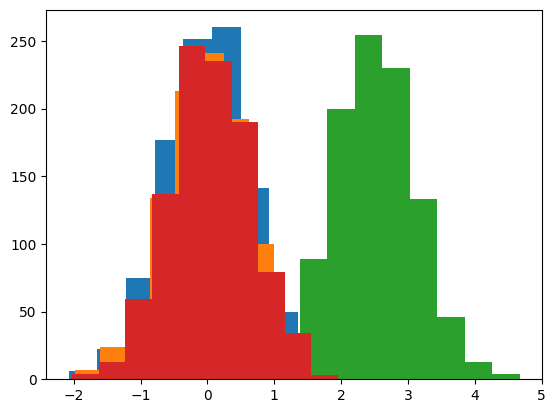

In [76]:
plt.hist(loss_gradients_BS[:,0])
plt.hist(loss_gradients_BS[:,1])
plt.hist(loss_gradients_BS[:,2])
plt.hist(loss_gradients_BS[:,3])

(array([994.,   2.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([1.64715716e-20, 6.86524232e-12, 1.37304846e-11, 2.05957265e-11,
        2.74609693e-11, 3.43262120e-11, 4.11914530e-11, 4.80566975e-11,
        5.49219385e-11, 6.17871795e-11, 6.86524240e-11]),
 <BarContainer object of 10 artists>)

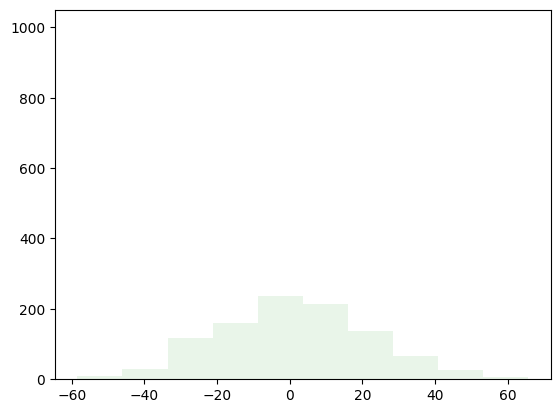

In [80]:
plt.hist(param_gradient_pBS[5][:,0].numpy().squeeze(),alpha=0.1)
plt.hist(param_gradient_pBS[5][:,1].numpy().squeeze(),alpha=0.1)
plt.hist(param_gradient_pBS[5][:,2].numpy().squeeze(),alpha=0.1)
plt.hist(param_gradient_pBS[5][:,3].numpy().squeeze(),alpha=0.1)

(array([994.,   2.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([1.64715716e-20, 6.86524232e-12, 1.37304846e-11, 2.05957265e-11,
        2.74609693e-11, 3.43262120e-11, 4.11914530e-11, 4.80566975e-11,
        5.49219385e-11, 6.17871795e-11, 6.86524240e-11]),
 <BarContainer object of 10 artists>)

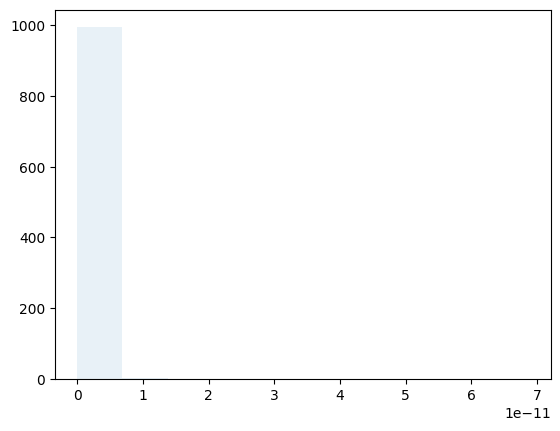

In [81]:

plt.hist(param_gradient_pBS[5][:,3].numpy().squeeze(),alpha=0.1)

In [88]:
np.mean(param_gradient_pBS[5][:,2].numpy())

1.1542351

In [109]:
dir(mixture_model)

['_Distribution__cached_batch_shape',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__abs__',
 '__abstractmethods__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array_priority__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__iter__',
 '__le__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pow__',
 '__radd__',
 '__rand__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rfloordiv__',
 '__rmatmul__',
 '__rmod__',
 '__rmul__',
 '__ror__',
 '__rpow__',
 '__rsub__',
 '__rtruediv__',
 '__rxor__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '__xor__',
 '_abc_impl',
 '_add_trackable_child',


In [123]:
mixture_model.mixture_distribution.parameters['probs'].numpy().round(2)

array([[[1. , 0. , 0.5, 0. ],
        [0. , 1. , 0.5, 0. ],
        [0. , 0. , 0. , 0. ],
        [0. , 0. , 0. , 1. ]]], dtype=float32)